loading data from /home/carnd/track2/
loading data from /home/carnd/rec2/
(32126, 7)
(8354, 7)


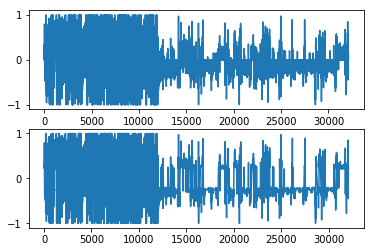

In [75]:
onServer = True

MIN_STEERING = 0.20
STEERING_ADJUST = 1

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

HOME_ROOT = '/Users/tempflip/Desktop/'
SERVER_ROOT = '/home/carnd/'


SERVER_LOG_DIR = '/home/carnd/track2/'
SERVER_LOG_DIR2 = '/home/carnd/rec2/'
LOG_FILE  = 'driving_log.csv'

#if onServer : dr = SERVER_LOG_DIR
#else : dr = LOG_DIR

row_list = []
def add_rows_to_rowlist(row_list, log_dir):
    print ('loading data from', log_dir)
    with open(log_dir + '/' + LOG_FILE, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            row[0] = row[0].replace(HOME_ROOT, SERVER_ROOT)
            row[1] = row[0].replace(HOME_ROOT, SERVER_ROOT)
            row[2] = row[0].replace(HOME_ROOT, SERVER_ROOT)
            row_list.append(row)
    return row_list

row_list = add_rows_to_rowlist(row_list, SERVER_LOG_DIR)
row_list = add_rows_to_rowlist(row_list, SERVER_LOG_DIR2)

log = []    
log = pd.DataFrame([row for row in row_list], columns=['CENTER', 
                                                         'LEFT',
                                                         'RIGHT',
                                                         'STEERING',
                                                         'THROTTLE',
                                                         'BRAKE',
                                                         'SPEED'
                                                        ])

log['STEERING'] = pd.to_numeric(log['STEERING'])

plt.subplot(2,1,1)
plt.plot(log['STEERING'])

print (log.values.shape)

clean_log = log[log['STEERING'].abs() > MIN_STEERING]


plt.subplot(2,1,2)
plt.plot(clean_log['STEERING'])


log = clean_log
print (log.values.shape)

#log['STEERING'] *= STEERING_ADJUST


In [76]:
print(log.iloc[4000])

CENTER      /home/carnd/track2/IMG/center_2017_03_15_08_53...
LEFT        /home/carnd/track2/IMG/center_2017_03_15_08_53...
RIGHT       /home/carnd/track2/IMG/center_2017_03_15_08_53...
STEERING                                             0.883209
THROTTLE                                                    0
BRAKE                                                       0
SPEED                                                29.59415
Name: 8352, dtype: object


In [77]:
from scipy import misc
im_list = []
steering_targets = []
STEERING_ADJUST = 0.2

data_list = []

item_num = len(log['CENTER'].values)
#item_num = 2000

for i in range(item_num):
    c, l, r = log[['CENTER', 'LEFT', 'RIGHT']].values[i]
    if onServer : 
        c = c.replace(LOG_DIR, SERVER_LOG_DIR)
        l = l.replace(LOG_DIR, SERVER_LOG_DIR)
        r = r.replace(LOG_DIR, SERVER_LOG_DIR)
    
    data_list.append((c, log['STEERING'].values[i]))
    
    # center camera
    #im = misc.imread(c)
    #im_list.append(im)
    #steering_targets.append(log['STEERING'].values[i])

    
    # left camera
    #im = misc.imread(l) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) + STEERING_ADJUST)    
    # right camera
    # left camera
    #im = misc.imread(r) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) - STEERING_ADJUST)  
    
#im_list = np.array(im_list, dtype=np.float32)
#steering_targets = np.array(steering_targets, dtype=np.float32)

#assert(steering_targets.shape[0] == im_list.shape[0])

print (len(data_list), 'points')



8354 points


In [78]:
from sklearn.utils import shuffle
# the generator
def generator(point_list, batch_size=100):  
    batch_size = int(batch_size / 2) # we are returning 2 images for one (flipped)
    while 1:
        point_list = shuffle(point_list)
        X, Y = [], []
        
        for i in range(batch_size):
            path, angle = point_list[i]
            angle = float(angle)
            im = misc.imread(path)
                        
            X.append(im)
            Y.append(angle)
            
            # the flipped image
            X.append(np.fliplr(im))
            Y.append(angle * -1)
            
        yield np.array(X, dtype=np.float32), np.array(Y)



In [79]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

def crop(d):
    return d[:,80:120,:,:]
    #return d[:,60:120,:,:]

def normalize(d):
    return d / 255 - 0.5

def reduce_palette(d):
    import tensorflow as tf 
    n = 40
    #n = 2
    return tf.ceil((d/n)*n)

def greyscale(d):
    import tensorflow as tf 
    r, g, b = tf.split(d, num_or_size_splits=3, axis=3)
    return (r + g + b) / 3

model = Sequential()

model.add(Lambda(reduce_palette, input_shape=(160, 320, 3)))
#model.add(Lambda(greyscale))
model.add(Lambda(normalize))
model.add(Lambda(crop))


model.add(Convolution2D(9,3,3, border_mode="same", name="conv1"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1)) #!!!!!!!!!
model.add(Activation('relu', name="relu1"))

model.add(Convolution2D(18,3,3, border_mode="same", name="conv2"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1)) #!!!!!!!!!!
model.add(Activation('relu', name="relu2"))


model.add(Flatten())

model.add(Dense(10))
model.add(Dense(1))

#print(model.inputs)
print(model.outputs)




[<tf.Tensor 'add_206:0' shape=(?, 1) dtype=float32>]


0.3110129


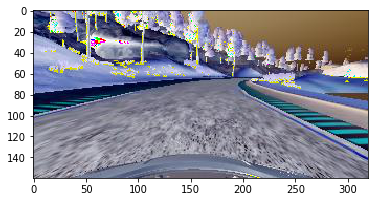

In [100]:
# some filter tests
g = generator(data_list, batch_size=20)
img, angle = next(g)
print (angle[0])

plt.imshow(img[0])

In [101]:
gen = generator(data_list, batch_size=500)
val_gen = generator(data_list, batch_size=100)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch = 8000, nb_epoch=10, validation_data=val_gen, nb_val_samples=50)


Epoch 1/10
8000/8000 [==============================] - 11s - loss: 0.2210 - acc: 0.0271 - val_loss: 0.1553 - val_acc: 0.0200

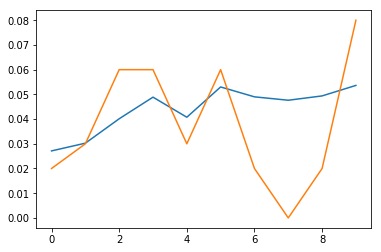

In [102]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [103]:
model.save('/home/carnd/mod.h5')
#model.save('./my_model.h5')
print("Saved.")

Saved.


In [10]:
from keras.models import load_model
from keras import backend as K
m = load_model('./my_model.h5')
m.load_weights('./my_model.h5')

Tensor("strided_slice_3:0", shape=(?, 40, 320, 3), dtype=float32) Tensor("add_29:0", shape=(?, 40, 320, 9), dtype=float32)


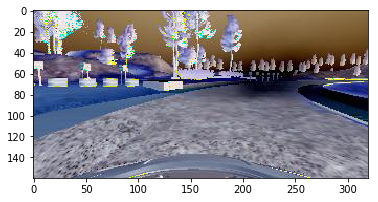

In [52]:
g = generator(data_list, batch_size=10)
_img, angle = next(g)

l = m.get_layer(name="conv1")
print(l.input, l.output)

img = _img[0]
plt.imshow(img)

(1, 1, 10, 80, 18)


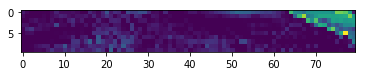

In [58]:


print (m.layers[5])

get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[8].output])


r = np.array(get_3rd_layer_output([[img]]))

print(r.shape)


plt.imshow(r[0,0,:,:,9])
